In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, time
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, fmin_cg, approx_fprime
from numpy.linalg import norm
from numpy import Inf
from tqdm import tqdm
from termcolor import colored, cprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import interp2d, SmoothBivariateSpline, RectBivariateSpline

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 2: calculating electron positions using `scipy.minimize` on a FEM obtained potential

In [3]:
save = False
data_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials"


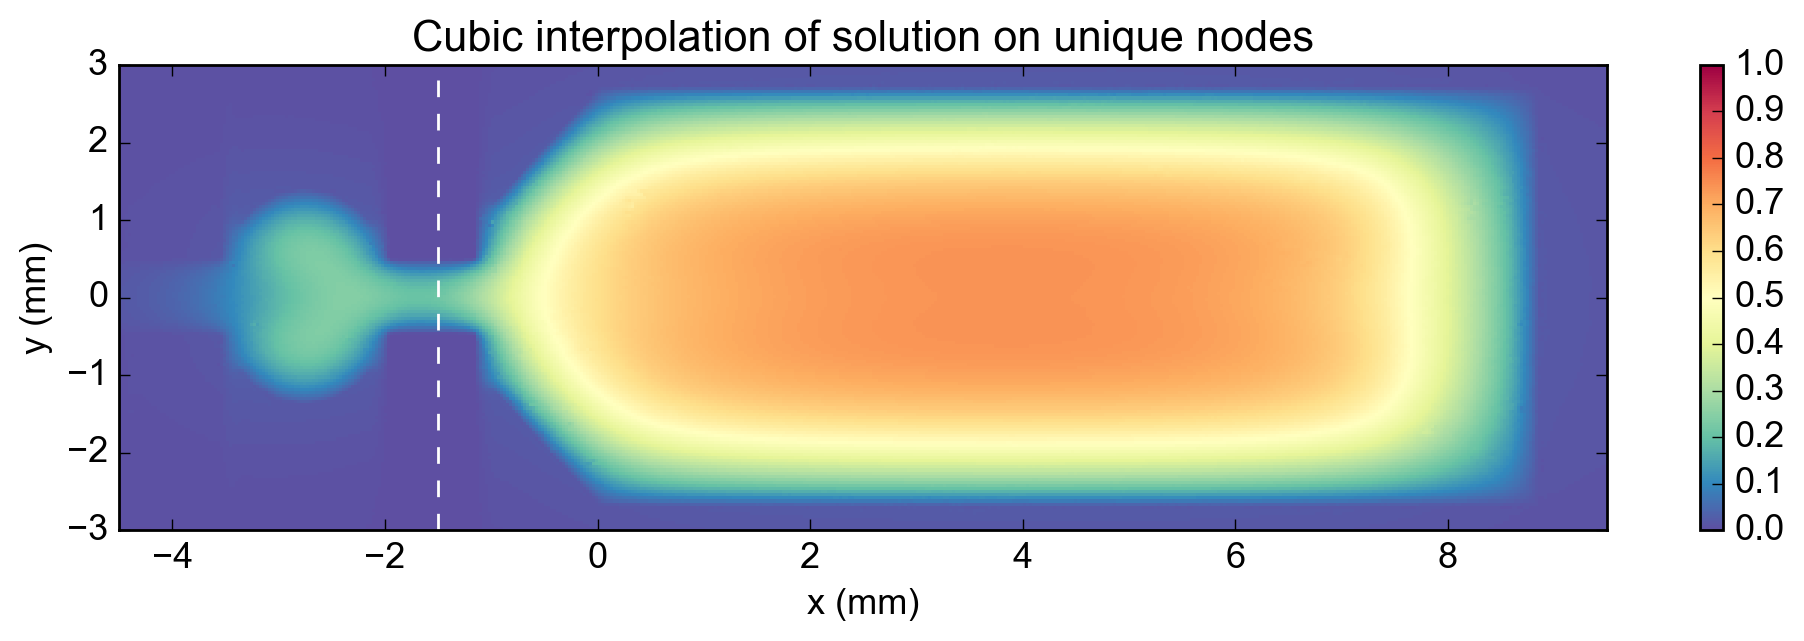

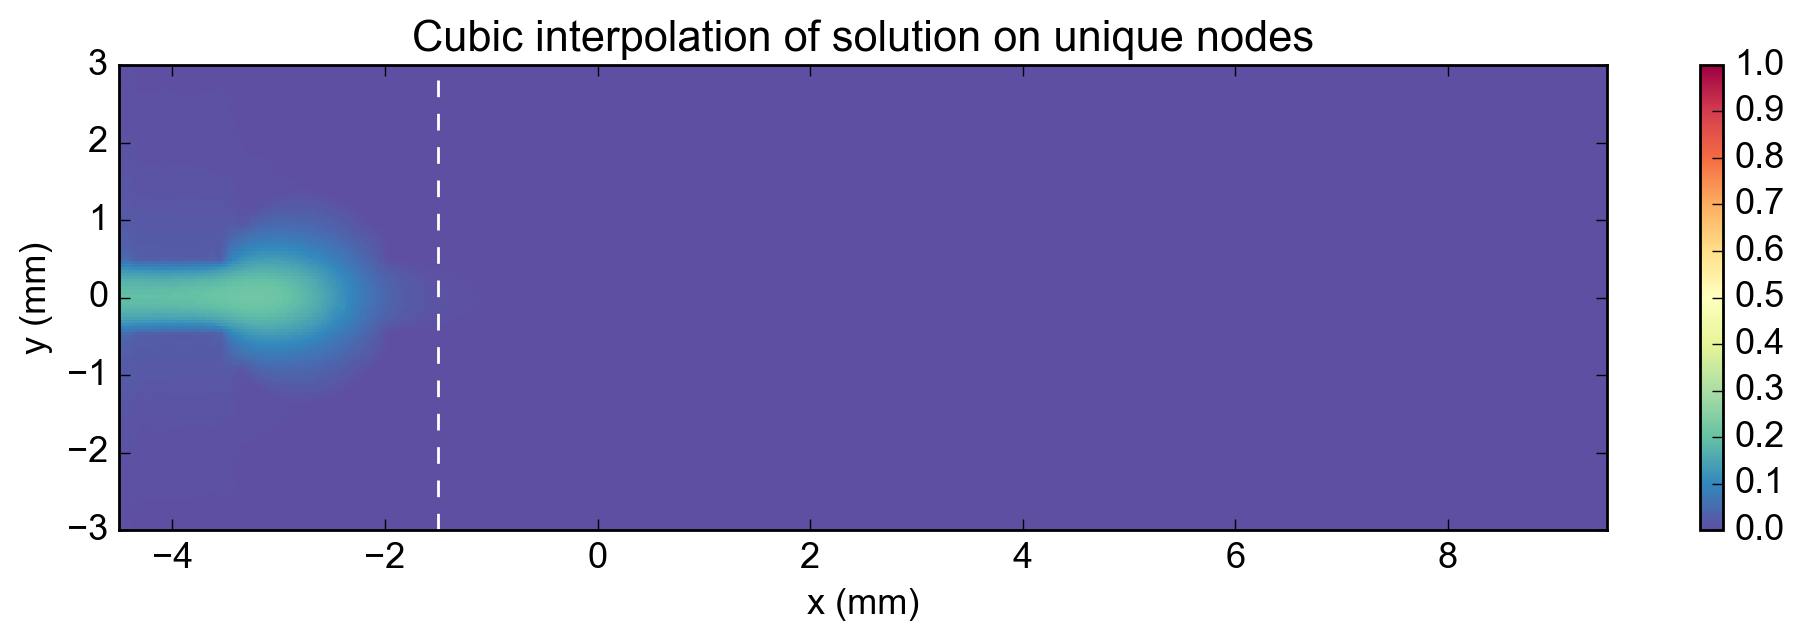

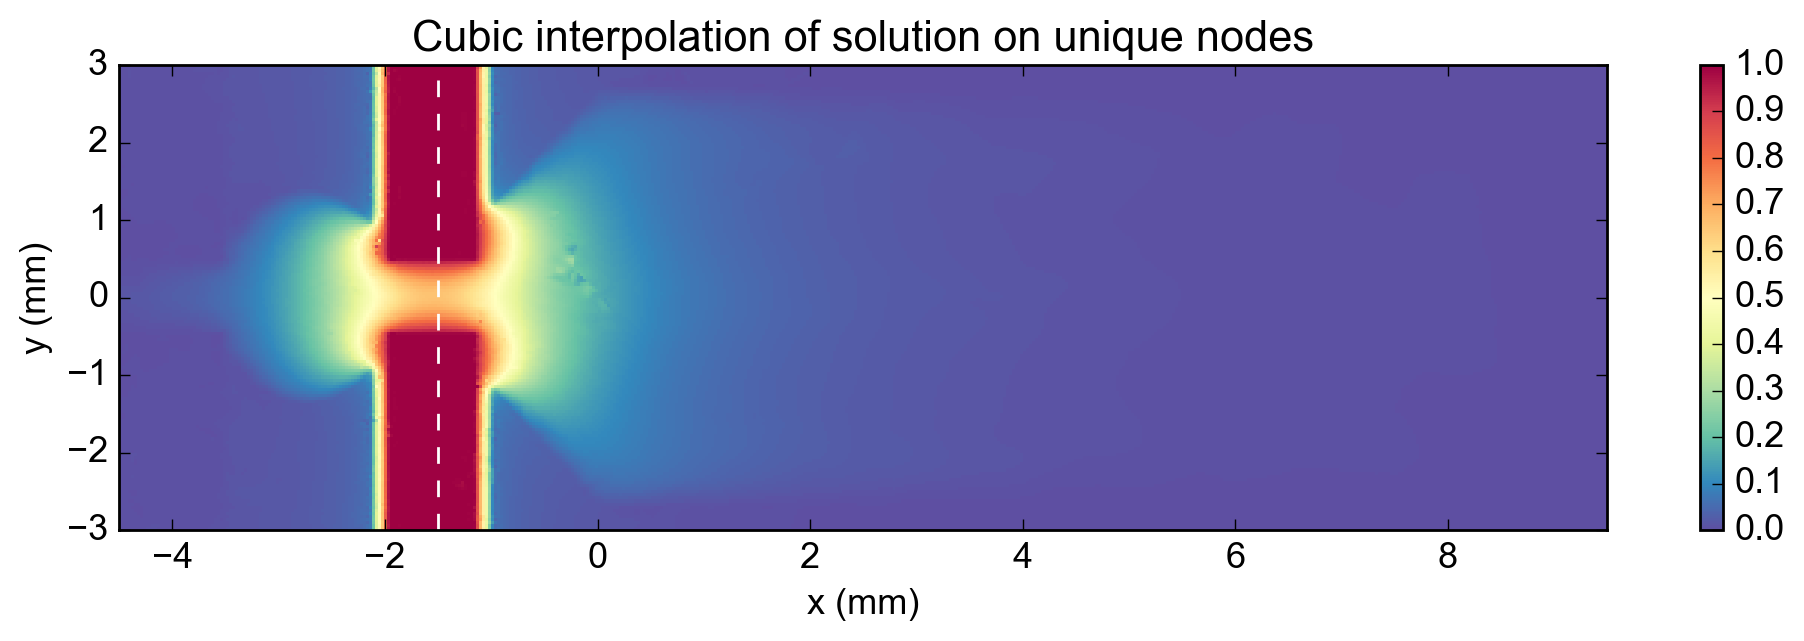

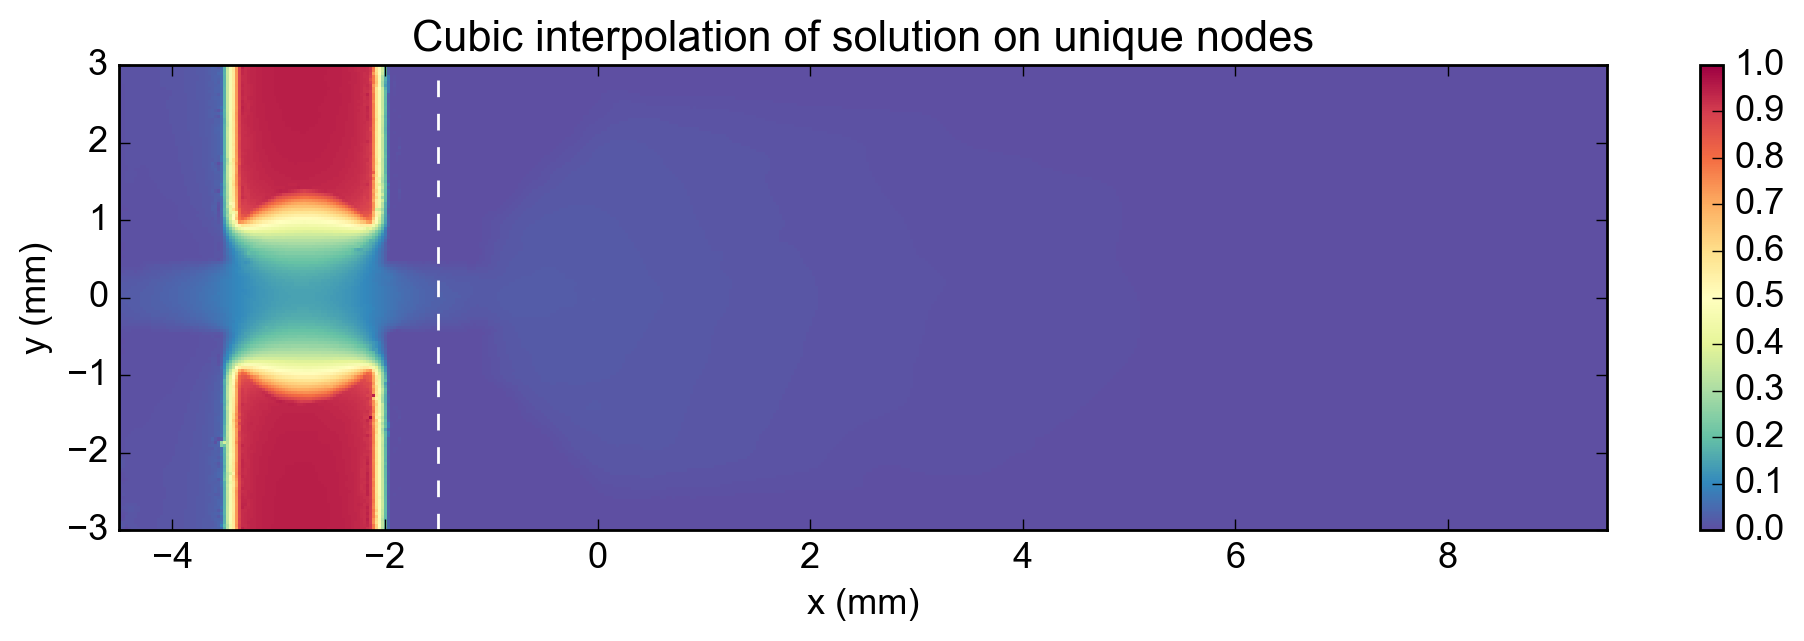

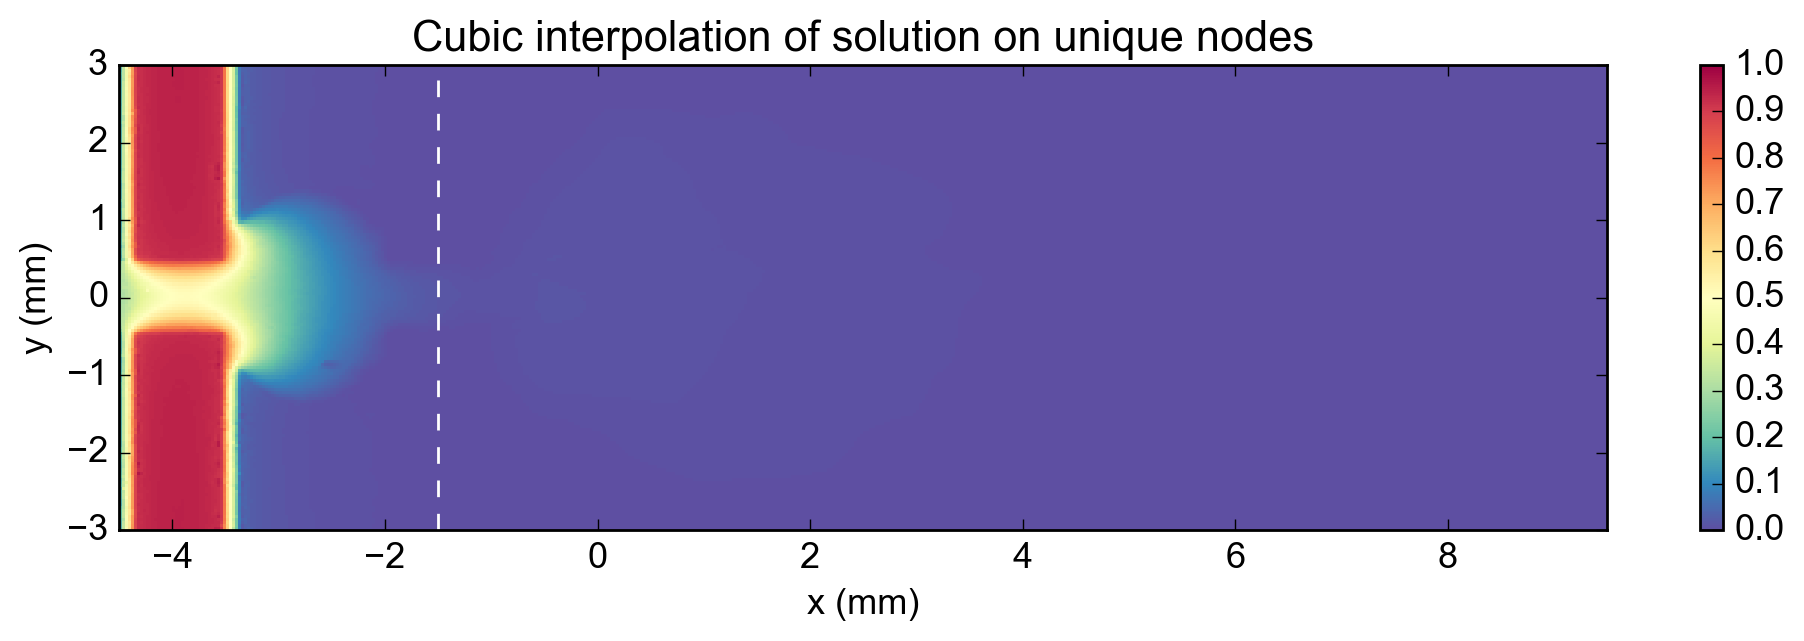

In [4]:
# Evaluate all files in the range
xeval=np.linspace(-4.5, 9.5, 501)
yeval = np.linspace(-3.0, 3.0, 151)

datafiles = [os.path.join(data_path, "Resonator.dsp"),
             os.path.join(data_path, "Trap.dsp"),
             os.path.join(data_path, "ResonatorGuard.dsp"),
             os.path.join(data_path, "CenterGuard.dsp"), 
             os.path.join(data_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(12.,3.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    #interpolate_slow.plot_mesh(os.path.join(datafile))
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=(0, 1.0), 
                                                         plot_axes='xy', cmap=plt.cm.Spectral_r, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    
    plt.vlines(-1.5, np.min(yeval), np.max(yeval), linestyles="--", color="white")

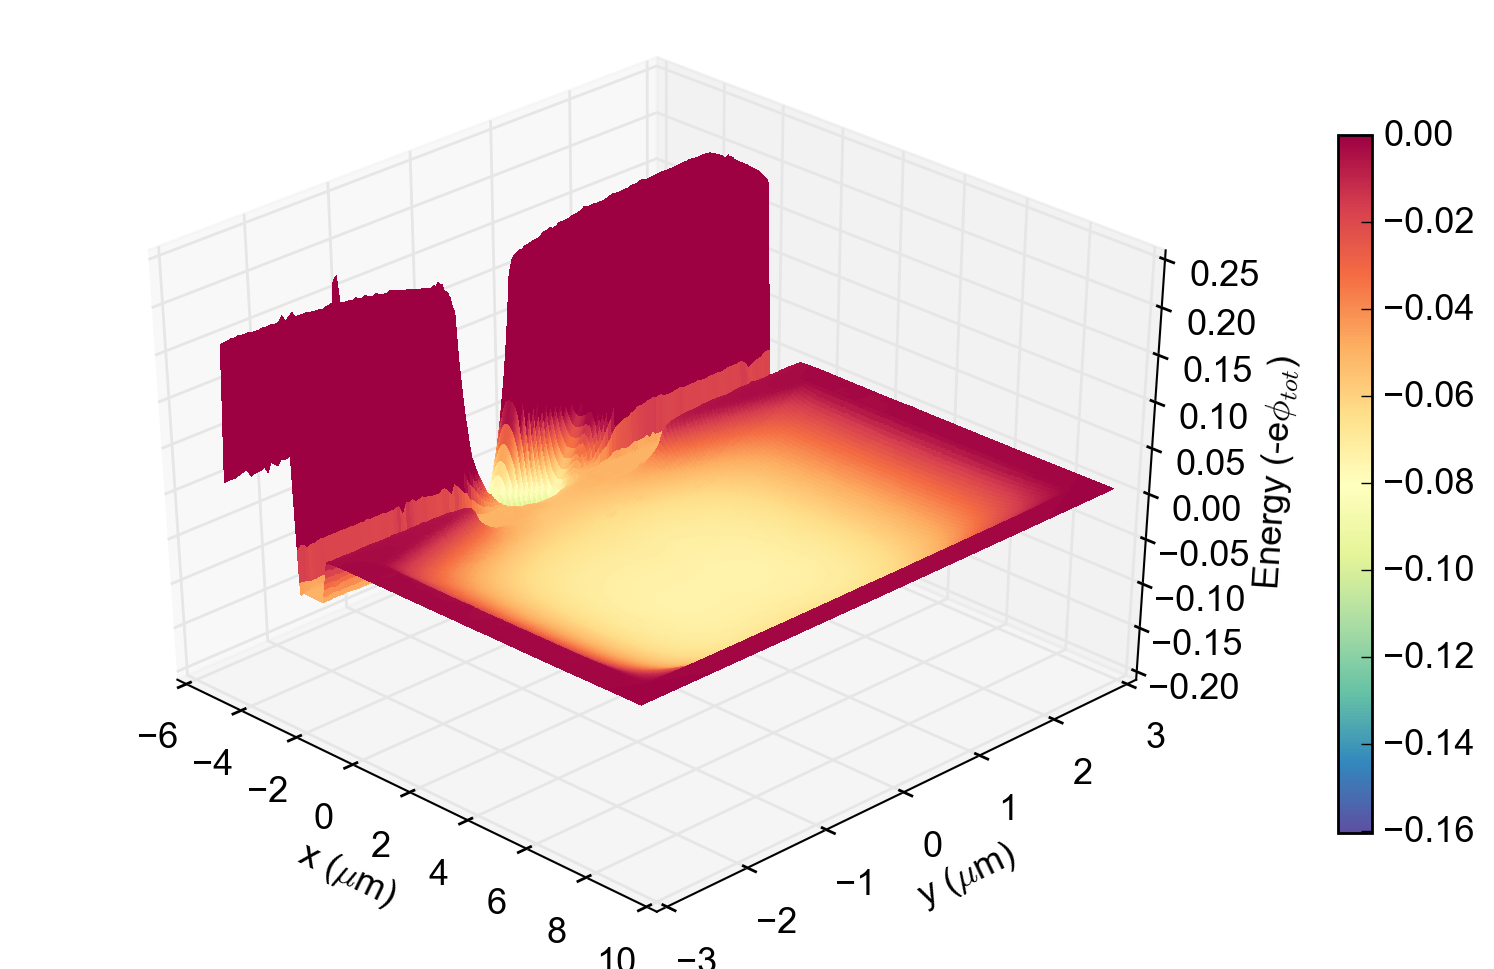

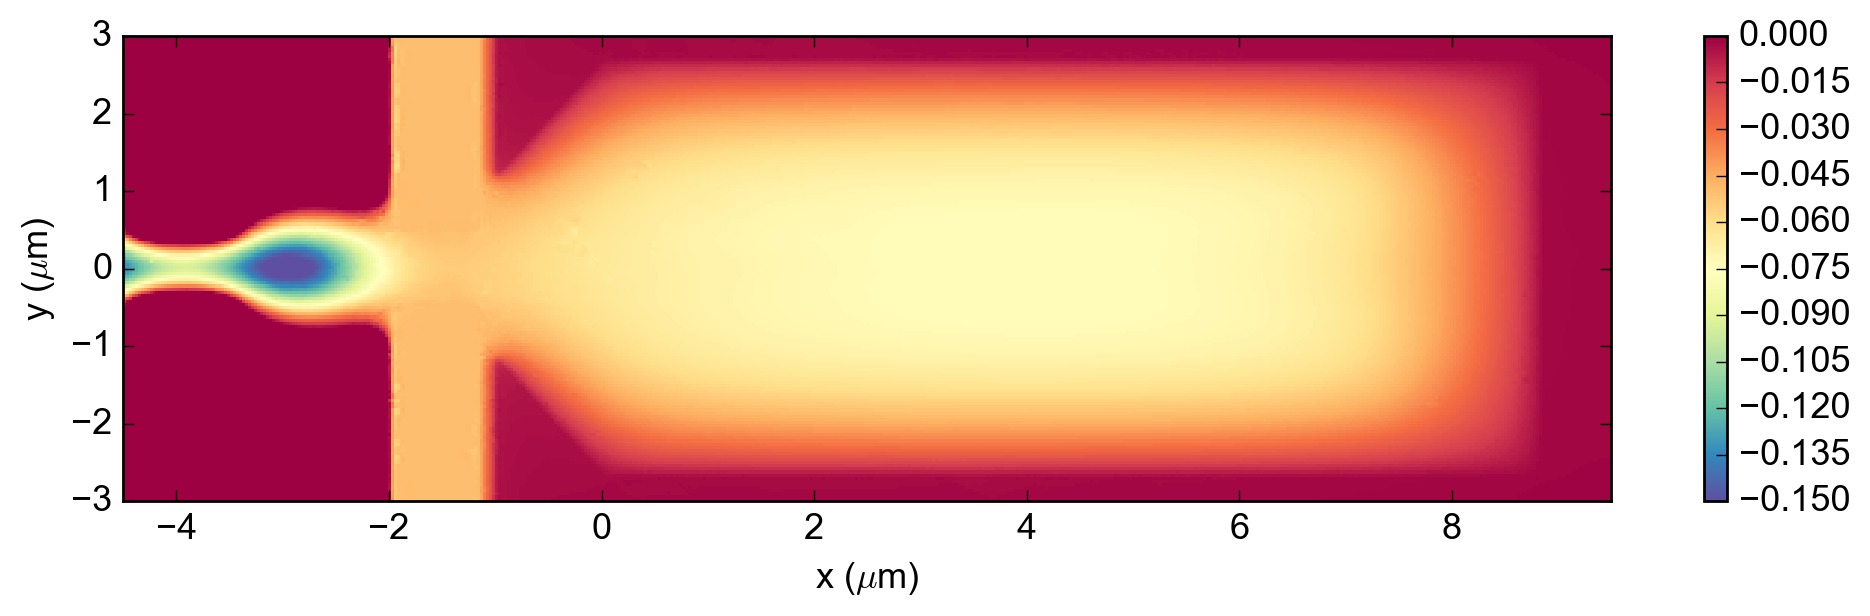

In [5]:
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()

Vres = 0.10
Vtrap = 1.00
Vrg = 0.05
Vcg = -0.20
Vtg = -0.20

xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

Xm, Ym = np.meshgrid(xeval, yeval)

for view_angle in [-45]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -combined_potential, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False, vmax=0.0)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)  
    
fig = plt.figure(figsize=(12.,3.))
common.configure_axes(13)
plt.pcolormesh(Xm, Ym, -combined_potential, cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.15)
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.colorbar()

In [6]:
EP = anneal.ElectrostaticPotential(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                                   spline_order_x=3, spline_order_y=3, smoothing=0.01)

Verify that the above interpolation function represents the FEM data: 

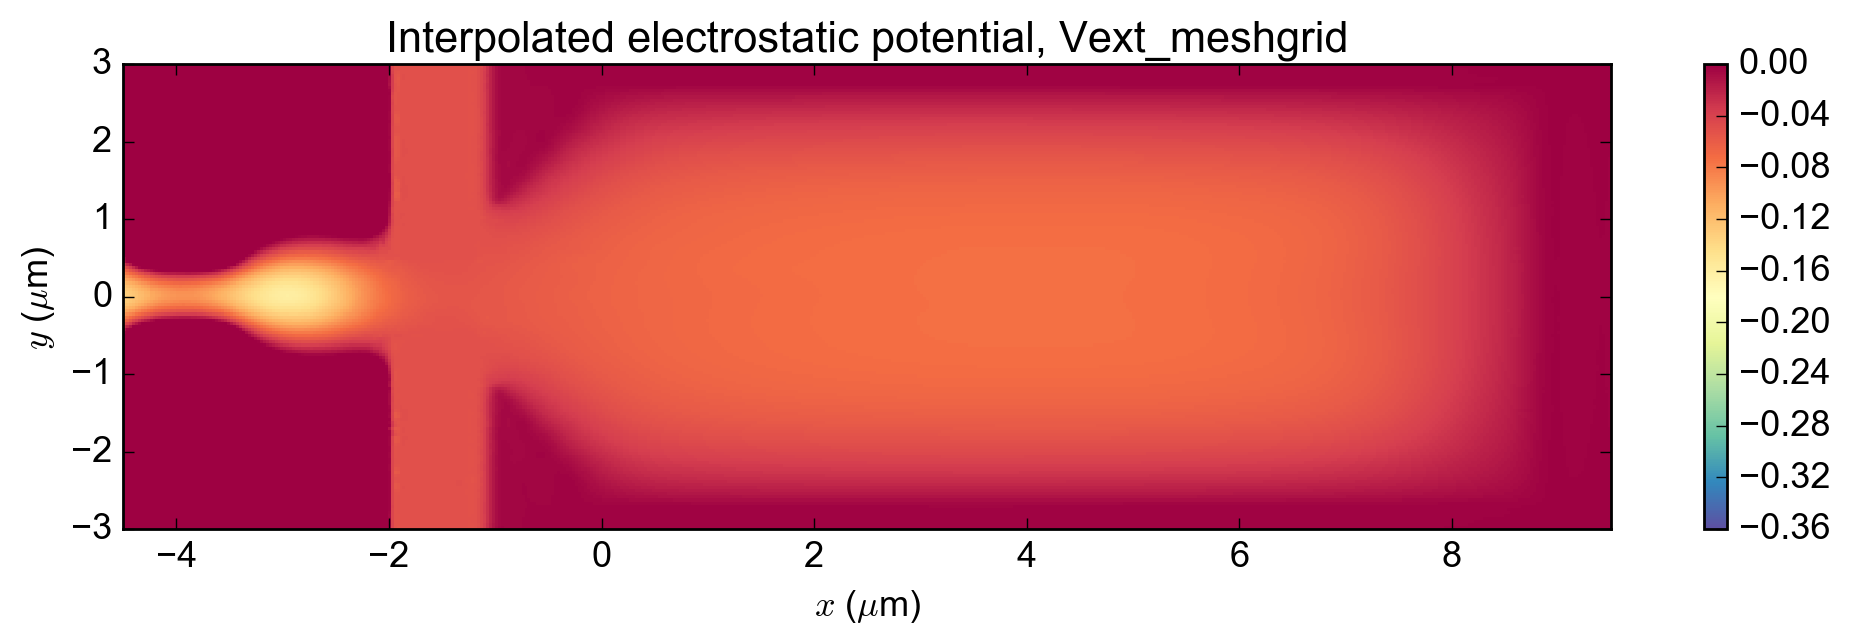

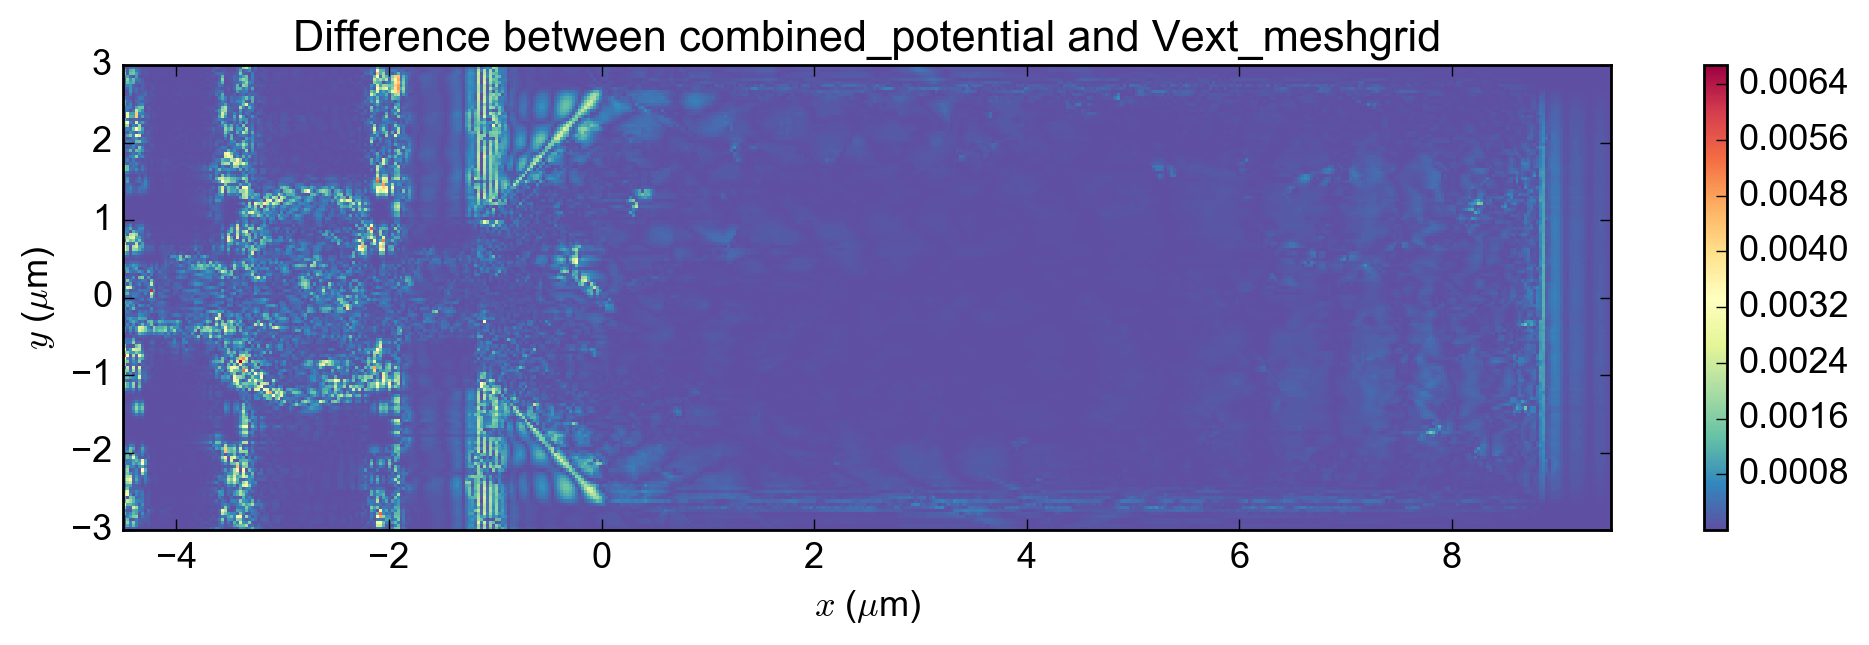

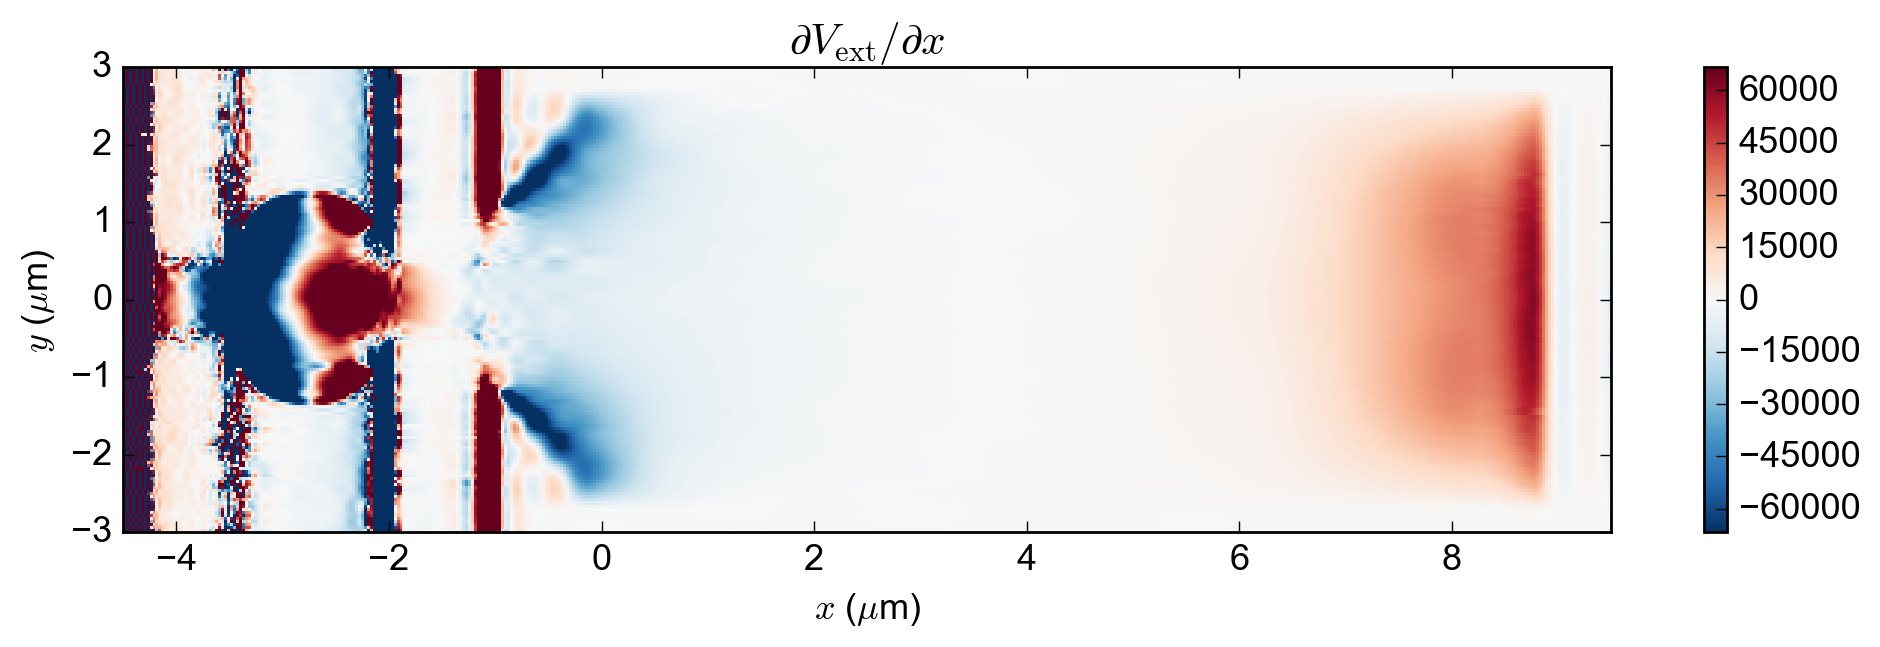

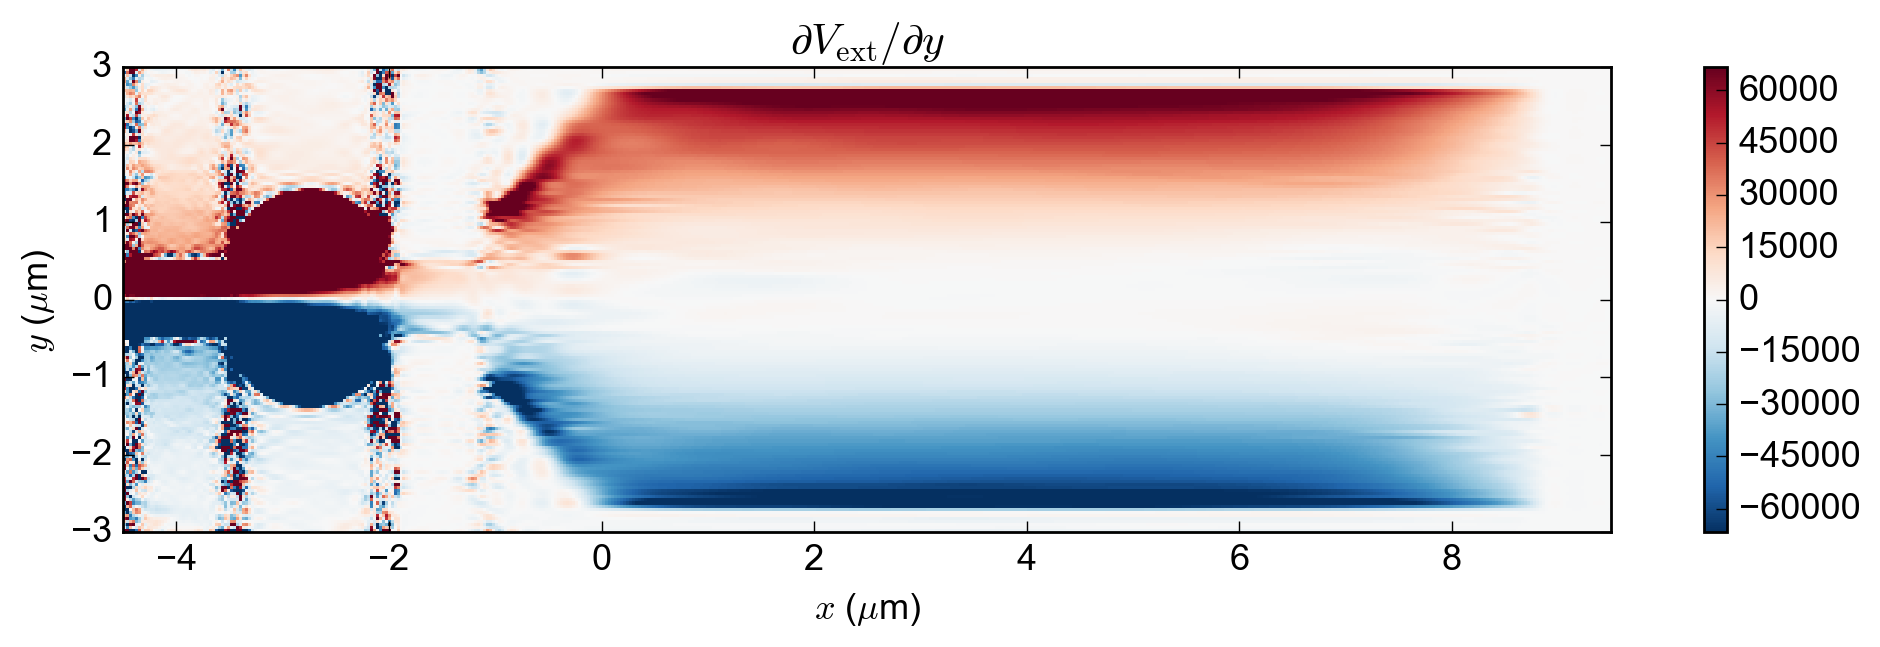

In [7]:
xtest = xeval*1E-6
ytest = yeval*1E-6
Xtest, Ytest = np.meshgrid(xtest, ytest)

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.V(Xtest, Ytest), vmax=0.00, vmin=-0.36, cmap=plt.cm.Spectral_r)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title("Interpolated electrostatic potential, Vext_meshgrid")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

if 1:
    plt.figure(figsize=(12.,3.))
    plt.pcolormesh(Xtest*1E6, Ytest*1E6, np.abs(EP.V(Xtest, Ytest)- (-combined_potential)), 
                   cmap=plt.cm.Spectral_r)
    plt.colorbar()
    plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
    plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
    plt.title(r"Difference between combined_potential and Vext_meshgrid")
    plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdx(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial x$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdy(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial y$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")


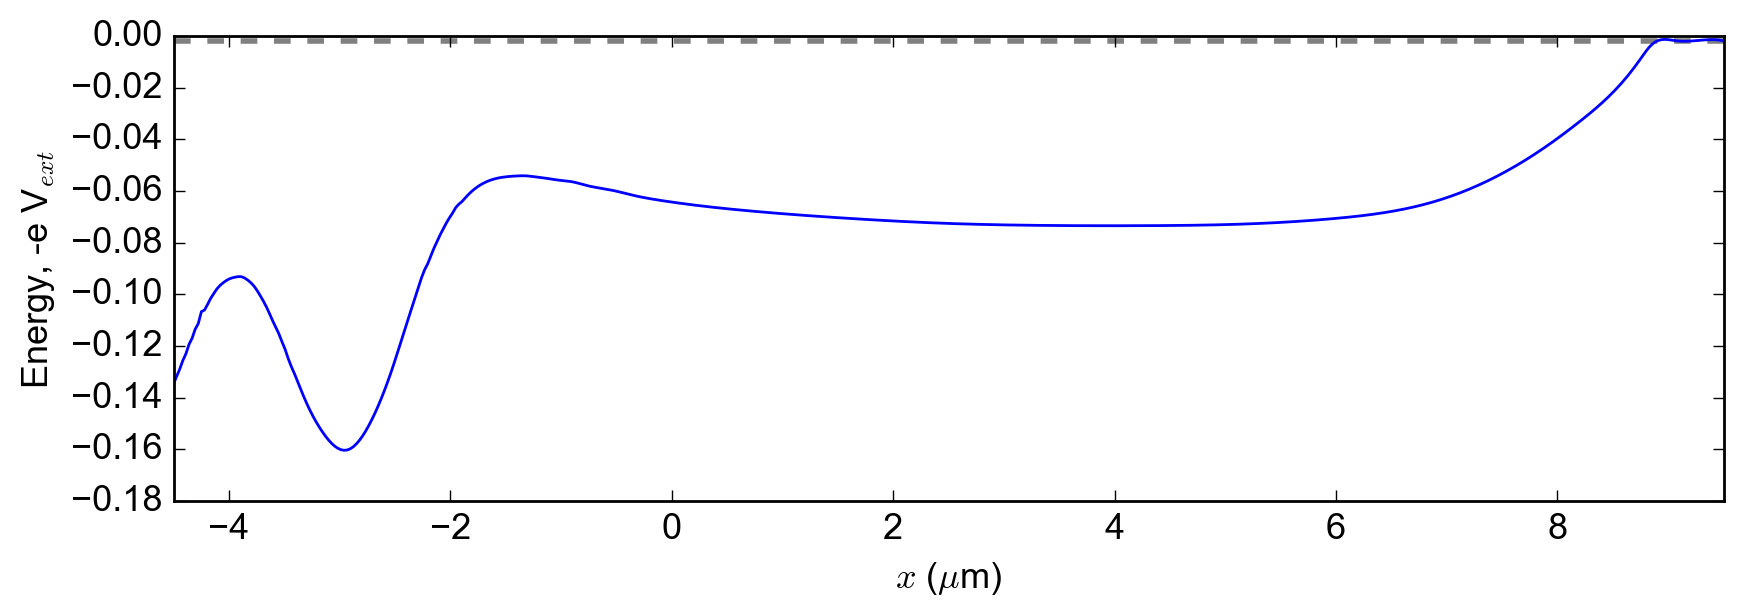

In [8]:
plt.figure(figsize=(10.,3.))
plt.plot(xeval, EP.V(xeval*1E-6, 0E-6))
plt.xlim(np.min(xeval), np.max(xeval))
plt.hlines(EP.V(xeval*1E-6, 0E-6)[-1], np.min(xeval), np.max(xeval), linestyles='--', color='gray', lw=2.0)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy, -e V$_{ext}$")

# Voltage sweep

In [36]:
Vres = 0.18
Vtrap_sweep = np.linspace(1.00, 1.50, 101)
Vrg = 0.10
Vcg = 0.00
Vtg = -0.20

epsilon = 1e-12
use_gradient = True
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Voltage sweep"
simulation_name = "Vtrap_sweep"

Start with a rectangular grid. Then for each subsequent voltage point, use the previous solution as initial condition.

In [37]:
N_electrons = 50

# Rectangle
N_cols = 10
N_rows = 5
if N_cols*N_rows != N_electrons:
    raise ValueError("N_cols and N_rows are not compatible with N_electrons")
else:
    separation = 200E-9
    x0 = 3.5E-6
    xs = np.linspace(x0, x0+N_cols*separation, N_cols)
    xinit = np.tile(np.array(xs), N_rows)
    ys = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
    yinit = np.repeat(ys, N_cols)

electron_initial_positions = anneal.xy2r(xinit, yinit)

In [38]:
def thermal_kick_x(x, y, T):
    kB = 1.38E-23
    qe = 1.602E-19
    ktrapx = np.abs(qe*EP.ddVdx(xi=x, yi=y))
    return np.sqrt(2*kB*T/ktrapx)

def thermal_kick_y(x, y, T):
    kB = 1.38E-23
    qe = 1.602E-19
    ktrapy = np.abs(qe*EP.ddVdy(xi=x, yi=y))
    return np.sqrt(2*kB*T/ktrapy)

0it [00:00, ?it/s]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


1it [00:05,  5.90s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


2it [00:12,  6.07s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


3it [00:18,  6.06s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


4it [00:23,  5.87s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


5it [00:29,  5.79s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


6it [00:34,  5.66s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


7it [00:40,  5.71s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


8it [00:46,  5.79s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


9it [00:52,  5.90s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


10it [01:00,  6.48s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


11it [01:07,  6.69s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


12it [01:15,  6.99s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


13it [01:23,  7.17s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


14it [01:31,  7.55s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


15it [01:39,  7.76s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


16it [01:49,  8.24s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


17it [01:58,  8.48s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


18it [02:05,  8.27s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


19it [02:15,  8.59s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


20it [02:23,  8.56s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


21it [02:31,  8.40s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


22it [02:39,  8.14s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


23it [02:47,  8.04s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


24it [02:54,  7.96s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


25it [03:02,  7.77s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


26it [03:10,  8.01s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K


27it [03:18,  7.81s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


28it [03:26,  7.91s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


29it [03:33,  7.70s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


30it [03:41,  7.74s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


31it [03:48,  7.64s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


32it [03:57,  8.03s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


33it [04:06,  8.23s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


34it [04:15,  8.47s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


35it [04:23,  8.43s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


36it [04:33,  8.81s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


37it [04:40,  8.19s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


38it [04:46,  7.67s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


39it [04:54,  7.64s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


40it [05:01,  7.44s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


41it [05:09,  7.86s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


42it [05:16,  7.56s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


43it [05:24,  7.46s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


44it [05:31,  7.32s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


45it [05:38,  7.23s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


46it [05:44,  7.12s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


47it [05:51,  6.97s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


48it [05:58,  6.94s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


49it [06:06,  7.18s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K


50it [06:12,  6.99s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


51it [06:19,  6.97s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


52it [06:25,  6.75s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


53it [06:33,  6.96s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K


54it [06:40,  6.99s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


55it [06:47,  7.05s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


56it [06:54,  7.09s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


57it [07:00,  6.71s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


58it [07:08,  6.97s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


59it [07:14,  6.91s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


60it [07:25,  8.09s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K


61it [07:34,  8.15s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


62it [07:40,  7.71s/it]

Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-0

63it [07:43,  6.18s/it]

There is a lower energy state, but the minimizer did not converge
Optimization failed! Not saving step #62
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


64it [07:52,  6.95s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


65it [08:09,  9.96s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


66it [08:21, 10.76s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


67it [08:28,  9.44s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


68it [08:34,  8.53s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


69it [08:41,  7.98s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


70it [08:49,  8.15s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


71it [08:58,  8.30s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


72it [09:05,  7.81s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K


73it [09:12,  7.71s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


74it [09:19,  7.61s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


75it [09:27,  7.61s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


76it [09:34,  7.30s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


77it [09:42,  7.58s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


78it [09:50,  7.64s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


79it [09:57,  7.64s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


80it [10:06,  7.87s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


81it [10:14,  7.98s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


82it [10:24,  8.62s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


83it [10:30,  7.88s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


84it [10:36,  7.41s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


85it [10:43,  7.15s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


86it [10:50,  7.01s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


87it [10:56,  6.65s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


88it [11:02,  6.50s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


89it [11:09,  6.62s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


90it [11:15,  6.69s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


91it [11:22,  6.62s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


92it [11:28,  6.48s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


93it [11:36,  6.84s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


94it [11:42,  6.77s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


95it [11:48,  6.46s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


96it [11:55,  6.57s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


97it [12:01,  6.32s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


98it [12:07,  6.20s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


99it [12:13,  6.23s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


100it [12:19,  6.13s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


101it [12:26,  6.38s/it]


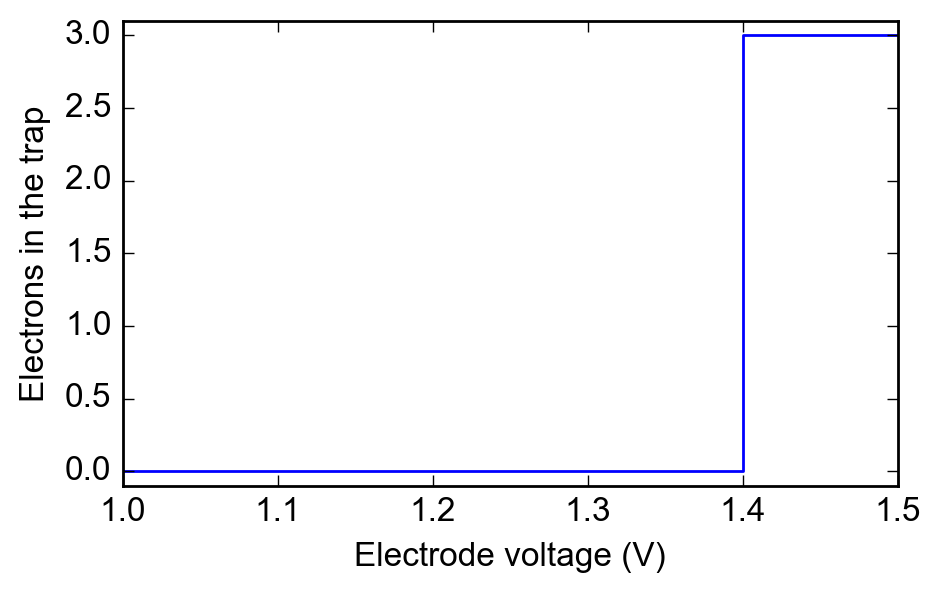

In [39]:
electrons_in_trap = list()
successful_V = list()
annealing_steps = [0.5]*10
num_trapped_electrons = list()
reload(anneal)

sub_dir = time.strftime("%y%m%d_%H%M%S_{}".format(simulation_name))
os.mkdir(os.path.join(save_path, sub_dir))
time.sleep(1)
os.mkdir(os.path.join(save_path, sub_dir, "Figures"))
os.mkdir(os.path.join(save_path, sub_dir, "Movie"))
os.mkdir(os.path.join(save_path, sub_dir, "Data"))

for k, Vtrap in tqdm(enumerate(Vtrap_sweep)):
    
    xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
    coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

    EP = anneal.ElectrostaticPotential(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                                       spline_order_x=3, spline_order_y=3, smoothing=0.01)

    ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=EP.grad_total, N=500, Uext=EP.V, 
                                        xext=xeval*1E-6, yext=yeval*1E-6, verbose=False, eps=epsilon, 
                                        save_path=os.path.join(save_path, sub_dir, "Figures"))

    if use_gradient: 
        jac=EP.grad_total
    else:
        jac = None
    
    
    # First minimization...
    res = minimize(EP.Vtotal, electron_initial_positions, method='CG', 
                   jac=jac, 
                   options={'disp': False, 'gtol' : 1E-1}, 
                   callback=ConvMon.monitor_convergence)
    
    
    # Perturb the system to see if we got the global minimum.
    perturbed_positions = np.zeros(len(electron_initial_positions))
    x_a, y_a = anneal.r2xy(res['x']) 
    final_func_val = res['fun']

    # Restart convergence monitor
    ConvMon.call_counter = 0
    ConvMon.figsize = (8.,2.)
    
    valid_solution = res

    for A, T in enumerate(annealing_steps):    
        cprint("Perturbing final state at T = %.2e K"%(T), 'blue')

        perturbed_x = x_a + thermal_kick_x(x_a, y_a, T) * np.random.rand(len(x_a))
        perturbed_y = y_a + thermal_kick_y(x_a, y_a, T) * np.random.rand(len(y_a))

        perturbed_positions[::2] = perturbed_x
        perturbed_positions[1::2] = perturbed_y

        res = minimize(EP.Vtotal, perturbed_positions, method='CG', 
                       jac=jac, 
                       options={'disp': False, 'gtol' : 1E-1}, 
                       callback=ConvMon.monitor_convergence)

        PP = anneal.PostProcess(save_path=os.path.join(save_path, sub_dir, "Figures"))
        num_trapped_electrons.append(PP.get_trapped_electrons(res['x']))

        if res['fun'] < final_func_val and res['status'] == 0:
            final_func_val = res['fun']
            x_pre_anneal, y_pre_anneal = anneal.r2xy(res['x'])
            jac_pre_anneal = np.amax(np.abs(res['jac']))
            valid_solution = res

        elif res['fun'] < final_func_val and res['status'] > 0:
            cprint("There is a lower energy state, but the minimizer did not converge", "red")

        elif res['fun'] >= final_func_val and res['status'] > 0:
            cprint("Minimizer did not converge, but this is not a lower energy state", "magenta")
    
    if valid_solution["status"] == 0:
        #cprint("Optimization successful.", 'green')
        
        x, y = anneal.r2xy(valid_solution['x'])
        final_func_val = valid_solution['fun']
        n_iterations = valid_solution['nit']

        Xeval, Yeval = np.meshgrid(xeval*1E-6, yeval*1E-6)

        save_dict = {"potential_x" : xeval*1E-6,
                     "potential_y" : yeval*1E-6,
                     "potential_V" : EP.V(Xeval, Yeval), 
                     "potential_coefficients" : coefficients,
                     "use_gradient" : use_gradient,
                     "electron_final_coordinates" : valid_solution['x'],
                     "electron_initial_coordinates" : electron_initial_positions,
                     "solver_result" : valid_solution}

        PP = anneal.PostProcess(save_path=os.path.join(save_path, sub_dir, "Figures"))
        PP.save_snapshot(valid_solution['x'], xext=xeval*1E-6, yext=yeval*1E-6, 
                         Uext=EP.V, clim=(-0.20, 0), 
                         common=common, figsize=(8.,2.), title="V = %.5f V"%Vtrap)
        PP.save_path = os.path.join(save_path, sub_dir, "Data")
        PP.write2file(**save_dict)

        successful_V.append(Vtrap)
        electrons_in_trap.append(PP.get_trapped_electrons(valid_solution['x']))
        
        # Use solution as initial condition for next voltage point
        electron_initial_positions = valid_solution['x']
    else:
        cprint("Optimization failed! Not saving step #%d"%k, 'red')   
        
# Save the 
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.step(successful_V, electrons_in_trap)
plt.ylim((-0.1, np.max(electrons_in_trap)+0.1))
plt.xlim(np.min(Vtrap_sweep), np.max(Vtrap_sweep))
plt.ylabel("Electrons in the trap")
plt.xlabel("Electrode voltage (V)")
fig.savefig(os.path.join(save_path, sub_dir, "Electrons_in_trap.png"), dpi=300, bbox_inches='tight')

# Create a movie
ConvMon.create_movie(fps=10, 
                     filenames_in=time.strftime("%Y%m%d")+"_figure_%05d.png", 
                     filename_out="%d_electrons_electrode_sweep.mp4"%(N_electrons))

# Move the file from the Figures folder to the Movie folder
os.rename(os.path.join(save_path, sub_dir, "Figures/%d_electrons_electrode_sweep.mp4"%(N_electrons)), \
          os.path.join(save_path, sub_dir, "Movie/%d_electrons_electrode_sweep.mp4"%(N_electrons)))

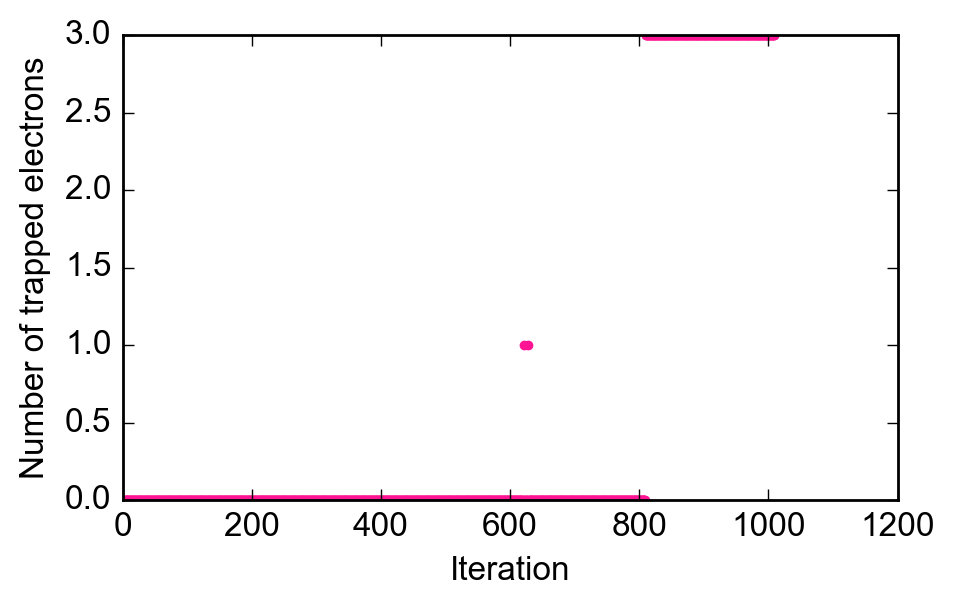

In [40]:
# Plot number of trapped electrons
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(num_trapped_electrons, '.', color='deeppink')
plt.xlabel("Iteration")
plt.ylabel("Number of trapped electrons")

In [87]:
ConvMon.create_movie(fps=10, 
                     filenames_in=time.strftime("%Y%m%d")+"_figure_%05d.png", 
                     filename_out="%d_electrons_electrode_sweep.mp4"%(N_electrons))

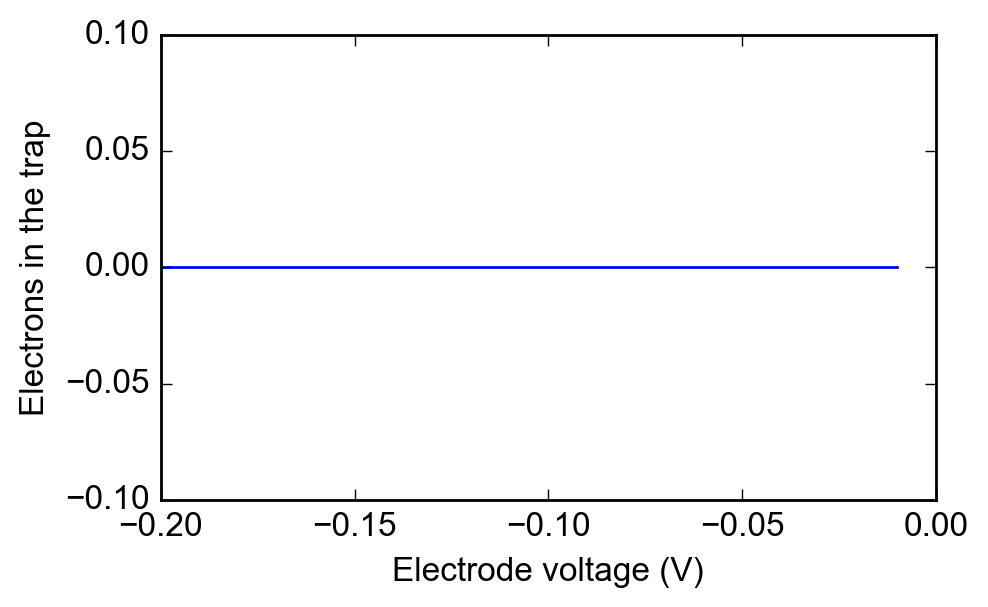

In [65]:
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.step(Vtrap_sweep[:len(electrons_in_trap)], electrons_in_trap)
plt.ylim((-0.1, np.max(electrons_in_trap)+0.1))
plt.xlim(np.min(Vtrap_sweep), np.max(Vtrap_sweep))
plt.ylabel("Electrons in the trap")
plt.xlabel("Electrode voltage (V)")

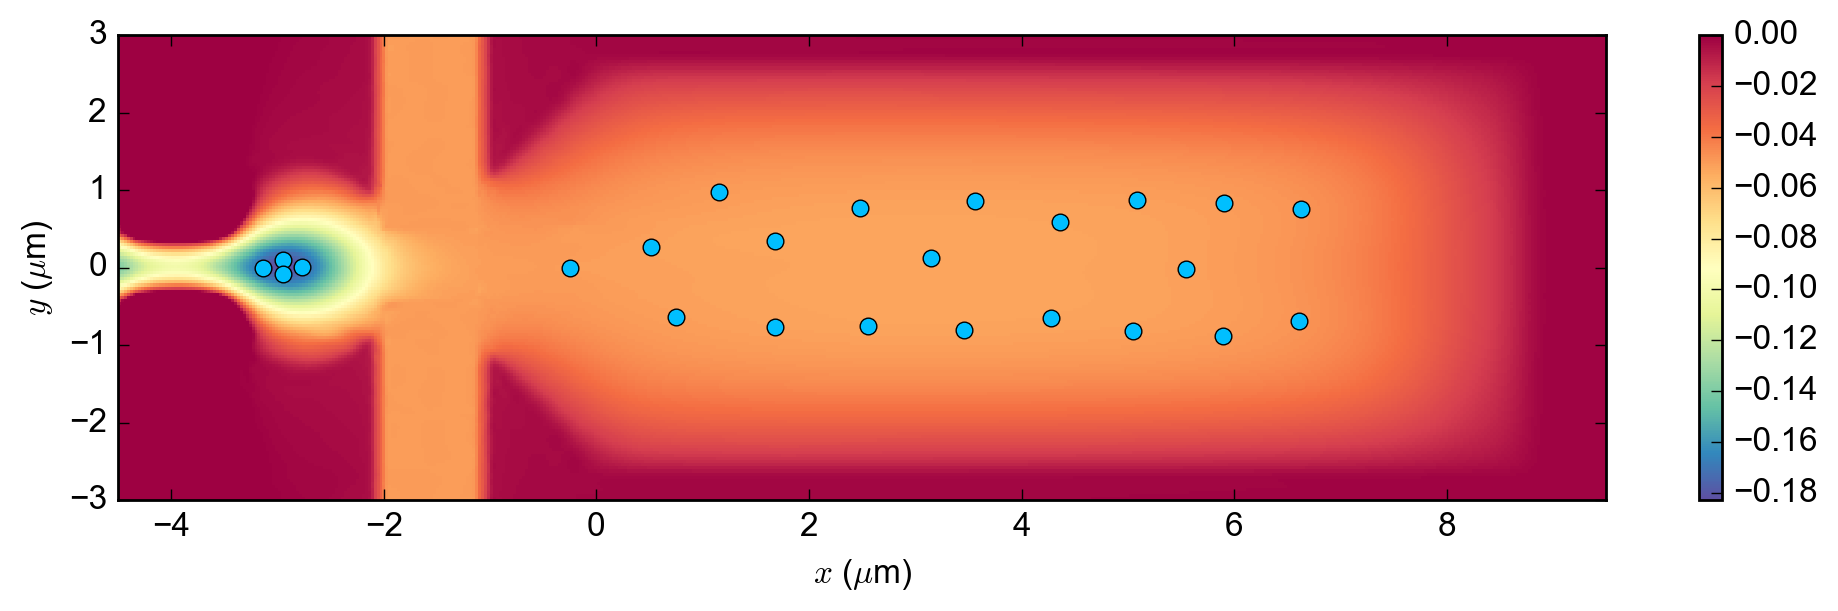

In [31]:
%matplotlib inline

Xinit, Yinit = anneal.map_into_domain(xinit, yinit)
X, Y = anneal.map_into_domain(res['x'][::2], res['x'][1::2])
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)